# Intro

This notebook visualizes the prediction results from all models after training.

# Load libs

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
%load_ext kedro.ipython

[07/09/24 12:31:53] INFO     Registered line magic '%reload_kedro'                                   ]8;id=273498;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=645674;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#58\58]8;;\

                    INFO     Registered line magic '%load_node'                                      ]8;id=161531;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=770016;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#60\60]8;;\

                    INFO     Resolved project path as: /home/filip/projects/HexGIN.                 ]8;id=962699;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=399782;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#171\171]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[07/09/24 12:31:53] WARNING  /home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro_ ]8;id=120398;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=633644;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/warnings.py#110\110]8;;\
                             viz/integrations/kedro/hooks.py:13: KedroDeprecationWarning:                          
                             'TRANSCODING_SEPARATOR' has been moved to                                             
                             'kedro.pipeline.transcoding', and the alias will be removed in Kedro                  
                             0.20.0                                                                                
                               from kedro.pipeline.pipeline import TRANSCODING_SEPARATOR,                          
                             _strip_transcoding                                                                    
                                                                                                                   

                    INFO     Kedro project HexGIN                                                   ]8;id=979540;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=414358;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#141\141]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=81062;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=281022;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#142\142]8;;\
                             'pipelines'                                                                           

[07/09/24 12:31:54] WARNING  /home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro_ ]8;id=640516;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/warnings.py\warnings.py]8;;\:]8;id=58511;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/warnings.py#110\110]8;;\
                             viz/models/flowchart.py:14: KedroDeprecationWarning:                                  
                             'TRANSCODING_SEPARATOR' has been moved to                                             
                             'kedro.pipeline.transcoding', and the alias will be removed in Kedro                  
                             0.20.0                                                                                
                               from kedro.pipeline.pipeline import TRANSCODING_SEPARATOR,                          
                             _strip_transcoding                                                                    
                                                                                                                   

[07/09/24 12:31:55] WARNING  Failed to load kedro_viz.launchers.jupyter commands from                  ]8;id=122598;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/framework/cli/utils.py\utils.py]8;;\:]8;id=627306;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/framework/cli/utils.py#379\379]8;;\
                             EntryPoint(name='line_magic',                                                         
                             value='kedro_viz.launchers.jupyter:run_viz', group='kedro.line_magic').               
                             Full exception: No module named 'toposort'                                            

In [3]:
%reload_kedro

                    INFO     Resolved project path as: /home/filip/projects/HexGIN.                 ]8;id=301919;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=349427;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#171\171]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

                    INFO     Kedro project HexGIN                                                   ]8;id=818325;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=999569;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#141\141]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=466275;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=74105;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/ipython/__init__.py#142\142]8;;\
                             'pipelines'                                                                           

                    WARNING  Failed to load kedro_viz.launchers.jupyter commands from                  ]8;id=512968;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/framework/cli/utils.py\utils.py]8;;\:]8;id=719314;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/framework/cli/utils.py#379\379]8;;\
                             EntryPoint(name='line_magic',                                                         
                             value='kedro_viz.launchers.jupyter:run_viz', group='kedro.line_magic').               
                             Full exception: No module named 'toposort'                                            

# Data load


In [4]:
cv_metrics = catalog.load("crossval_metrics")
bootstrap_metrics = catalog.load("bootstrap_metrics")

                    INFO     Loading data from crossval_metrics (CSVDataset)...                 ]8;id=41857;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=491967;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from bootstrap_metrics (CSVDataset)...                ]8;id=957957;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=957769;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

In [5]:
melted_data = cv_metrics.melt(id_vars=['model', 'fold'], value_vars=['precision', 'f1', 'recall', 'rocauc'], var_name='metric')

In [6]:
melted_data.groupby(['model', 'metric']).agg({'value': ['mean', 'median', 'std']}).T

model           HexGIN                                     MLP            \
metric              f1 precision    recall    rocauc        f1 precision   
value mean    0.792805  0.780591  0.833446  0.882490  0.733434  0.716719   
      median  0.802199  0.755657  0.868922  0.886749  0.736437  0.719263   
      std     0.048941  0.082192  0.130771  0.035190  0.067037  0.087609   

model                                 SAGE                                
metric          recall    rocauc        f1 precision    recall    rocauc  
value mean    0.787696  0.816003  0.747410  0.691161  0.851543  0.820183  
      median  0.852008  0.812708  0.757817  0.649128  0.928118  0.828944  
      std     0.161541  0.056979  0.034044  0.083198  0.141885  0.031477

In [7]:
writer = pd.ExcelWriter("bottstrapped_metrics_stats.xlsx")

In [8]:
melted_data.groupby(['model', 'metric']).agg({'value': ['mean', 'median', 'std']}).T.round(3).to_excel(writer, sheet_name='overall_results')

# Bootstrap metrics

In [9]:
sort_dict = {'HexGIN': 1, 'SAGE': 2, 'MLP': 3}
bootstrap_metrics.sort_values(by=['model'], ascending=True, inplace=True, key=lambda x: x.map(sort_dict))
bootstrap_metrics.round(4)

,model,metric,CI low,CI high
0,HexGIN,f1,0.7774,0.8057
1,HexGIN,precision,0.7578,0.8026
2,HexGIN,recall,0.7950,0.8698
3,HexGIN,rocauc,0.8715,0.8921
4,SAGE,f1,0.7370,0.7564
5,SAGE,precision,0.6699,0.7150
6,SAGE,recall,0.8099,0.8892
7,SAGE,rocauc,0.8107,0.8283
8,MLP,f1,0.7147,0.7519
9,MLP,precision,0.6940,0.7390


In [10]:
bootstrap_metrics.round(4).to_excel(writer, sheet_name='bootstrap_results')
writer.close()

In [11]:
def plot_confidence_interval(x, ci_lo, ci_hi, ax, color='#2187bb', horizontal_line_width=0.6):
    mean = (ci_lo + ci_hi) / 2.
    

    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    ax.plot([x, x], [ci_lo, ci_hi], color=color)
    ax.plot([left, right], [ci_hi, ci_hi], color=color)
    ax.plot([left, right], [ci_lo, ci_lo], color=color)
    ax.plot(x, mean, 'o', color='#f44336')

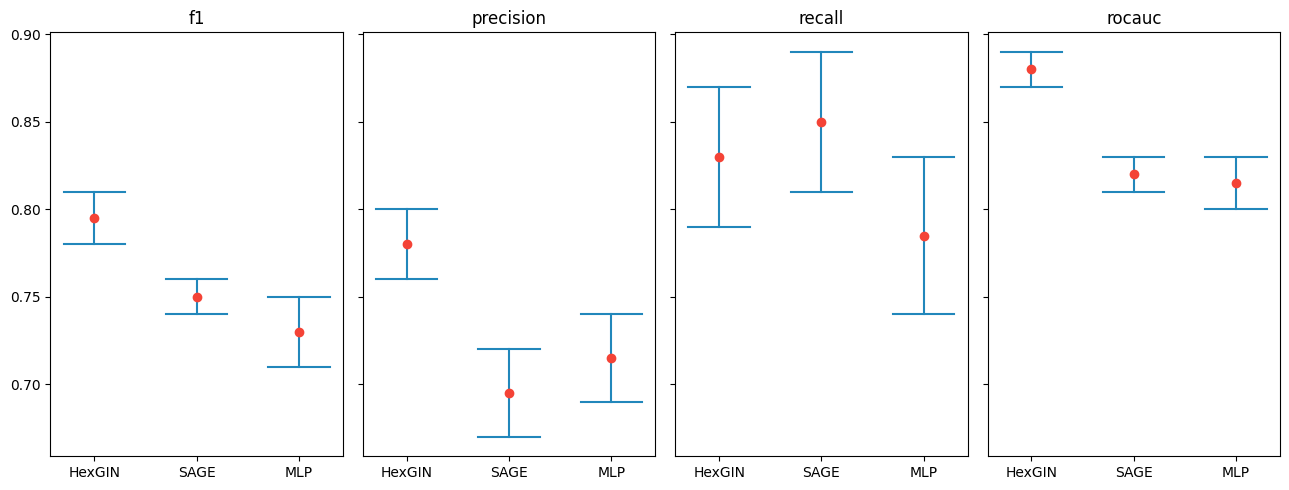

In [12]:
metrics = ['f1', 'precision', 'recall', 'rocauc']
f, axs = plt.subplots(1, len(metrics), figsize=(13, 5), sharey=True, sharex=True, layout='tight')
plt.subplots_adjust(wspace=0.5)
for i, metric in enumerate(metrics):
    ci_low = bootstrap_metrics.loc[bootstrap_metrics.metric == metric, 'CI low'].round(2)
    ci_hi = bootstrap_metrics.loc[bootstrap_metrics.metric == metric, 'CI high'].round(2)

    plt.xticks([0, 1, 2], ['HexGIN', 'SAGE', 'MLP'])
    ax = axs[i]
    plot_confidence_interval(0, ci_low.iloc[0], ci_hi.iloc[0], ax)
    plot_confidence_interval(1, ci_low.iloc[1], ci_hi.iloc[1], ax)
    plot_confidence_interval(2, ci_low.iloc[2], ci_hi.iloc[2], ax)
    ax.set_title(metric)
plt.show()

# Test metrics

In [13]:
hexgin_test_metrics = catalog.load("hexgin_test_report")
sage_test_metrics = catalog.load("sage_test_report")
mlp_test_metrics = catalog.load("mlp_test_report")

[07/09/24 12:31:57] INFO     Loading data from hexgin_test_report (CSVDataset)...               ]8;id=969001;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=338733;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from sage_test_report (CSVDataset)...                 ]8;id=3665;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=524310;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from mlp_test_report (CSVDataset)...                  ]8;id=527797;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=106120;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

In [14]:
hexgin_test_metrics = catalog.load("hexgin_metrics")
sage_test_metrics = catalog.load("sage_metrics")
mlp_test_metrics = catalog.load("mlp_metrics")

                    INFO     Loading data from hexgin_metrics (CSVDataset)...                   ]8;id=532213;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=36664;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from sage_metrics (CSVDataset)...                     ]8;id=535504;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=785890;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

                    INFO     Loading data from mlp_metrics (CSVDataset)...                      ]8;id=858756;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=412931;file:///home/filip/miniconda3/envs/hexgin/lib/python3.11/site-packages/kedro/io/data_catalog.py#508\508]8;;\

In [15]:
pd.concat([hexgin_test_metrics, sage_test_metrics, mlp_test_metrics], axis=0).round(3).reset_index(drop=True).style.highlight_max(
    axis=0,
    color='lightgreen',
    subset=['f1', 'precision', 'recall', 'rocauc'])

,f1,precision,recall,rocauc,model
0,0.715000,0.852000,0.616000,0.799000,HexGIN
1,0.680000,0.850000,0.567000,0.786000,SAGE
2,0.587000,0.705000,0.503000,0.694000,MLP
